# Tutorial: Privacidade Diferencial em Sistemas de Recomendação
**Autores:**
- Caio Uramoto Evangelista
- Murillo Domingos de Almeida

**Disciplina:**
- SCC0284 - Sistemas de Recomendação (ICMC-USP)

---

## 1. Introdução: O Dilema da Privacidade

Sistemas de recomendação que usamos diariamente (como **Netflix, Spotify ou Amazon**) dependem massivamente de dados comportamentais para funcionarem bem. Porém, o histórico dos filmes que assistimos ou dos produtos que compramos diz muito sobre quem somos, criando um risco real de exposição de dados sensíveis.

**A pergunta central deste tutorial é:**
> *Como podemos extrair padrões gerais de um grupo (ex: "Este filme é popular?") sem comprometer a privacidade individual de quem votou?*

A resposta para esse desafio é a **Privacidade Diferencial (Differential Privacy - DP)**. Considerada atualmente o "padrão-ouro" para proteção de dados, essa técnica já é utilizada em larga escala por organizações como **Apple, Google e o Censo dos EUA** para coletar estatísticas de uso sem espionar usuários individuais.

### Como funciona na prática?
A intuição por trás da Privacidade Diferencial é simples, mas poderosa: ela adiciona um **"ruído matemático"** calibrado às respostas das consultas (*queries*) feitas ao banco de dados.

Imagine que você quer calcular a nota média de um filme. Ao aplicar DP, o sistema não entrega a média exata, mas sim um valor muito próximo, levemente alterado pelo ruído.

O controle desse equilíbrio entre **proteção** e **precisão** é feito através de um parâmetro chamado **Épsilon ($\epsilon$)**:

* **$\epsilon$ Baixo (Muito Ruído):** Garante privacidade quase total, mas a utilidade do dado cai (a média pode ficar distorcida).
* **$\epsilon$ Alto (Pouco Ruído):** Mantém alta utilidade e precisão, mas oferece menor proteção à privacidade individual.

Neste tutorial, vamos explorar esse *trade-off* na prática, protegendo um dataset de avaliações de filmes e visualizando o impacto do ruído nos resultados.

---


## 2. Preparando o Ambiente

Para aplicar a Privacidade Diferencial sem precisar implementar a matemática complexa do zero, utilizaremos a biblioteca **Diffprivlib** (Differential Privacy Library), desenvolvida pela IBM. Ela fornece implementações seguras e testadas dos principais mecanismos de privacidade.

Além dela, usaremos:
* **Pandas:** Para organizar nossos dados em tabelas.
* **NumPy:** Para gerar os dados numéricos simulados.
* **Seaborn/Matplotlib:** Para criar os gráficos que nos ajudarão a visualizar o impacto do ruído.

In [5]:
# Instalando a biblioteca de Privacidade Diferencial da IBM
# O comando '!' indica que é uma instrução para o sistema do Google Colab, não Python puro.
!pip install diffprivlib pandas matplotlib seaborn

# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from diffprivlib.mechanisms import Laplace

# Configuração visual para os gráficos ficarem mais bonitos e legíveis
sns.set_theme(style = "whitegrid")

print("\n-> Ambiente configurado e bibliotecas instaladas com sucesso!")


-> Ambiente configurado e bibliotecas instaladas com sucesso!


---

## 3. Simulando o Cenário: O Caso "Toy Story"

Como não podemos utilizar dados reais de usuários sem permissão ética (o que violaria a própria privacidade que queremos proteger!), vamos simular um cenário controlado.

**O Cenário:**
Imagine que somos cientistas de dados de uma plataforma de streaming. Temos um banco de dados com **5.000 avaliações** de usuários para o filme *"Toy Story"*.
* As notas variam de **1 a 5 estrelas**.
* Como o filme é geralmente considerado "bom", a maioria das notas será 4 ou 5.

**Objetivo:**
Calcular a **Média Real** dessas notas. Este valor será nosso **"Ground Truth"** (a verdade absoluta). Em um mundo ideal (sem preocupações com privacidade), este seria o valor divulgado. Porém, nosso objetivo será chegar perto desse valor protegendo os dados individuais.

In [6]:
# 1. Fixando a "semente" aleatória
# Isso garante que, toda vez que rodarmos este tutorial, os números gerados sejam iguais.
np.random.seed(42)

# 2. Definindo as probabilidades para cada nota (1 a 5)
# Vamos simular que o filme é bom:
# Notas 1 e 2 tem pouca chance (5%)
# Nota 3 tem chance média (10%)
# Notas 4 e 5 tem chance alta (40%)
probabilidades = [0.05, 0.05, 0.10, 0.40, 0.40]

# 3. Gerando 5000 avaliações com base nessas chances
dados_reais = np.random.choice([1, 2, 3, 4, 5], size = 5000, p = probabilidades)

# 4. Criando um DataFrame (Tabela) para visualizar melhor
df = pd.DataFrame(dados_reais, columns = ["nota"])

# 5. Calculando a "Verdade Absoluta"
media_real = df["nota"].mean()

print(f"-> Total de Avaliações Geradas: {len(df)}")
print(f"-> Média REAL (Sem Privacidade): {media_real:.2f} estrelas\n")
print("-" * 30)
print("\n-> Amostra das primeiras 5 notas no banco de dados:")
df.head()

-> Total de Avaliações Geradas: 5000
-> Média REAL (Sem Privacidade): 4.04 estrelas

------------------------------

-> Amostra das primeiras 5 notas no banco de dados:


,nota
0,4
1,5
2,5
3,4
4,3


---

## 4. A Mecânica da Privacidade

Para proteger a média que calculamos, não podemos divulgar o valor exato. Se um atacante soubesse a média exata antes e depois de um novo usuário votar, ele poderia descobrir matematicamente qual nota esse usuário deu.

A solução é adicionar um **Ruído Estatístico** calibrado ao resultado. Faremos isso usando o **Mecanismo de Laplace**. Para configurar esse mecanismo, precisamos entender dois conceitos fundamentais:

### A. Sensibilidade ($S$)
A sensibilidade responde à pergunta: *"O quanto uma única pessoa consegue mudar o resultado final?"*
* No nosso caso, as notas vão de 1 a 5.
* Se trocarmos a nota de uma pessoa (digamos, de 1 para 5), a soma total das notas muda no máximo em **5 pontos**.
* Como estamos calculando a **média**, o impacto de uma pessoa é $5$ dividido pelo número total de pessoas ($N$).

### B. Épsilon ($\epsilon$) - O "Orçamento de Privacidade"
Este é o parâmetro que vocês vão ajustar. Pense nele como um botão de volume para o ruído:
* **$\epsilon$ ALTO (ex: 10.0):** Adiciona **pouco ruído**. O resultado é preciso, mas a privacidade é fraca.
* **$\epsilon$ BAIXO (ex: 0.1):** Adiciona **muito ruído**. A privacidade é forte, mas o resultado pode ficar distorcido.

Vamos implementar uma função que faz esse cálculo automaticamente.

In [7]:
"""
  Calcula a média de uma lista de dados aplicando Privacidade Diferencial
  usando o Mecanismo de Laplace.

  Parâmetros:
    dados: Lista ou array com as notas.
    epsilon: O "orçamento" de privacidade (quanto menor, mais privado).
    sensibilidade: O valor máximo que um dado individual pode assumir (default = 5).
"""
def calcular_media_privada(dados, epsilon, sensibilidade = 5):
    # 1. Definindo a Sensibilidade para a Média
    # O impacto de um usuário na média dilui conforme o tamanho da base (N).
    # Por isso, dividimos a sensibilidade pelo tamanho dos dados.
    sensibilidade_da_media = sensibilidade / len(dados)

    # 2. Configurando o Mecanismo de Laplace (da biblioteca diffprivlib)
    mecanismo = Laplace(epsilon = epsilon, sensitivity = sensibilidade_da_media)

    # 3. Calculando a média real (sem proteção)
    media_real = np.mean(dados)

    # 4. Aplicando o ruído (Randomização)
    # O mecanismo pega o valor real e sorteia um valor próximo, seguindo a curva de Laplace.
    media_privada = mecanismo.randomise(media_real)

    return media_privada

# Pequeno teste da função
print(f"-> Média REAL (Alvo): {media_real:.4f}\n")
print("-" * 30)

# Teste 1: Pouca Privacidade (Epsilon Alto = 10)
res_fraco = calcular_media_privada(dados_reais, epsilon = 10.0)
print(f"\n-> Epsilon 10.0 (Pouca Priv): {res_fraco:.4f} -> Erro: {abs(media_real - res_fraco):.4f}")

# Teste 2: Muita Privacidade (Epsilon Baixo = 0.1)
res_forte = calcular_media_privada(dados_reais, epsilon = 0.1)
print(f"-> Epsilon 0.1  (Muita Priv): {res_forte:.4f} -> Erro: {abs(media_real - res_forte):.4f}")

-> Média REAL (Alvo): 4.0396

------------------------------

-> Epsilon 10.0 (Pouca Priv): 4.0396 -> Erro: 0.0000
-> Epsilon 0.1  (Muita Priv): 4.0356 -> Erro: 0.0040


---

## 5. O Grande Experimento: Visualizando o Trade-off

Você deve ter notado nos testes anteriores que, às vezes, mesmo com muita privacidade (Epsilon baixo), o resultado sai próximo do real. Isso acontece porque o ruído é aleatório, podemos ter "sorte".

Porém, em sistemas críticos, não contamos com a sorte. Precisamos medir a **consistência**.

Para isso, vamos realizar um **Experimento de Monte Carlo**:
1. Vamos testar vários valores de Epsilon (do mais rigoroso ao mais relaxado).
2. Para cada Epsilon, vamos calcular a média **100 vezes seguidas**.
3. Vamos plotar a distribuição desses resultados para ver o quão "estável" é a nossa resposta.

A forma matemática do ruído que estamos injetando segue a **Distribuição de Laplace** (veja a imagem abaixo), que é mais "pontiaguda" no zero, mas tem caudas longas onde o erro pode ser grande.

-> Rodando simulação de Monte Carlo (100x por Epsilon).


/tmp/ipython-input-843738563.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "Epsilon", y = "Valor_Calculado", data = df_resultados, palette = "viridis")


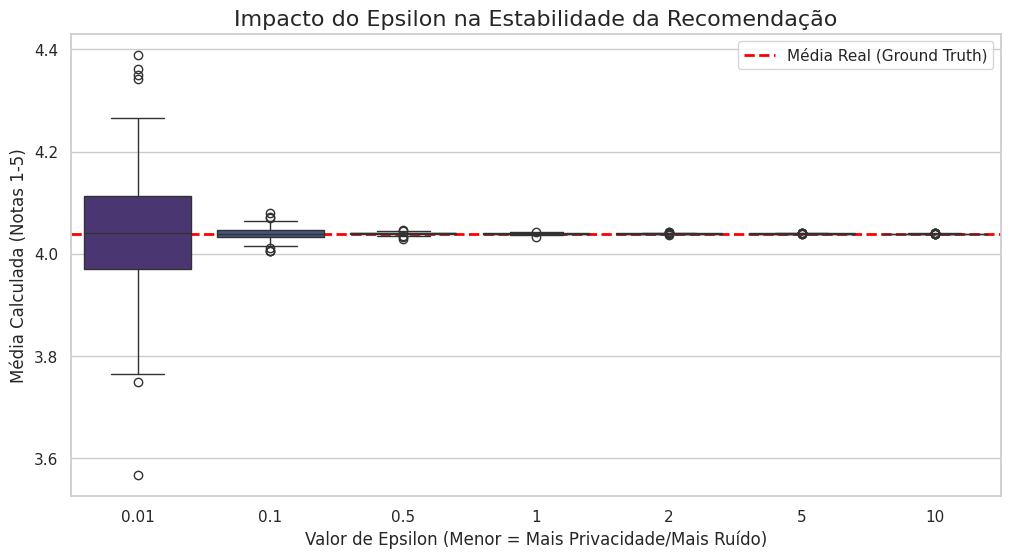

In [8]:
# 1. Definindo os cenários de teste
# Epsilons muito baixos (0.01) até muito altos (10)
epsilons_teste = [0.01, 0.1, 0.5, 1, 2, 5, 10]

# Lista para guardar os dados do experimento
resultados = []

print("-> Rodando simulação de Monte Carlo (100x por Epsilon).")

# 2. Loop do Experimento
for eps in epsilons_teste:
    for _ in range(100): # Repetimos 100 vezes para cada valor de epsilon

        media_estimada = calcular_media_privada(dados_reais, eps)

        # Guardamos o resultado num dicionário
        resultados.append({
            "Epsilon": str(eps), # Texto para o gráfico agrupar corretamente
            "Valor_Calculado": media_estimada
        })

# 3. Transformando em DataFrame para o Seaborn
df_resultados = pd.DataFrame(resultados)

# 4. Plotando o Gráfico (Boxplot)
plt.figure(figsize=(12, 6))

# Linha vermelha tracejada: O alvo (Média Real)
plt.axhline(y = media_real, color = "red", linestyle = "--", linewidth = 2, label = "Média Real (Ground Truth)")

# Boxplot: Mostra a variação dos dados
sns.boxplot(x = "Epsilon", y = "Valor_Calculado", data = df_resultados, palette = "viridis")

plt.title("Impacto do Epsilon na Estabilidade da Recomendação", fontsize = 16)
plt.xlabel("Valor de Epsilon (Menor = Mais Privacidade/Mais Ruído)", fontsize = 12)
plt.ylabel("Média Calculada (Notas 1-5)", fontsize = 12)
plt.legend()
plt.show()

---

## 6. Interpretando os Resultados

O gráfico acima (Boxplot) nos mostra como a precisão do sistema varia conforme ajustamos o "botão" da privacidade ($\epsilon$). Com nossa base de **5.000 avaliações**, observamos um comportamento muito favorável:

1.  **Epsilon 0.01 (Extrema Privacidade):**
    * Observe a caixa roxa à esquerda. Embora existam alguns *outliers* (pontos isolados que erraram a média), a grande maioria dos resultados (o corpo da caixa) já está concentrada entre **3.9 e 4.1**.
    * Isso indica que, devido ao bom volume de dados, conseguimos garantir privacidade total com uma perda de precisão aceitável.

2.  **Epsilon 0.1 (Alta Estabilidade):**
    * Neste ponto, a caixa se torna muito pequena e centralizada na linha vermelha.
    * A variação é mínima. Isso significa que o ruído adicionado é suficiente para proteger identidades, mas irrelevante para a estatística final.

3.  **Epsilon 0.5 em diante (Convergência):**
    * O gráfico vira praticamente uma linha reta. O resultado é idêntico ao cálculo sem privacidade.

### Conclusão do Tutorial
Este experimento demonstra que a **Privacidade Diferencial** é altamente eficaz, especialmente quando temos uma quantidade razoável de dados.

Não precisamos escolher entre "proteger o usuário" ou "ter um sistema útil". Ao escolher um $\epsilon$ equilibrado (neste caso, algo entre **0.1 e 0.5**), conseguimos o melhor dos dois mundos: estatísticas precisas e usuários protegidos.